In [1]:
import os
from numba import njit,jit
import numpy as np
from tqdm.notebook import tqdm as tqdmn

import seaborn as sns
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("Paired")+['#D3D3D3','#808080'])

import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import matplotlib.colors
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 0.2 #set the value globally
mpl.rcParams['xtick.major.width'] = 0.3
mpl.rcParams['xtick.minor.width'] = 0.3
mpl.rcParams['ytick.major.width'] = 0.3
mpl.rcParams['ytick.minor.width'] = 0.3

from netCDF4 import Dataset
import scipy.stats as sp
import adsfunc as ads

fpath = os.path.join(rcParams["datapath"], "/Users/felixlangot/Library/Fonts/Cronos-Pro-Light_12448.ttf")
Csprop = fm.FontProperties(fname=fpath)
Cstitleprop = Csprop.copy()
Cslabelprop = Csprop.copy()
Cstitleprop.set_size(30)
Csprop.set_size(25)
Cslabelprop.set_size(25)

fpath2 = os.path.join(rcParams["datapath"], "/Users/felixlangot/Library/Fonts/MinionPro-Regular.otf")
Mpprop = fm.FontProperties(fname=fpath2)
Mptitleprop = Mpprop.copy()
Mplabelprop = Mpprop.copy()
Mptitleprop.set_size(30)
Mpprop.set_size(25)
Mplabelprop.set_size(15)

fpath3 = os.path.join(rcParams["datapath"], "/Users/felixlangot/Library/Fonts/texgyrepagella-math.otf")
Tgprop = fm.FontProperties(fname=fpath3)
Tgtitleprop = Tgprop.copy()
Tglabelprop = Tgprop.copy()
Tgtitleprop.set_size(30)
Tgprop.set_size(25)
Tglabelprop.set_size(15)

In [2]:
%run dataCyclone30min.py

data:
QC ('time', 'z', 'y', 'x') (48, 68, 128, 128)
QI ('time', 'z', 'y', 'x') (48, 68, 128, 128)
QSAT ('time', 'z', 'y', 'x') (48, 68, 128, 128)
QV ('time', 'z', 'y', 'x') (48, 68, 128, 128)
QVMPHY ('time', 'z', 'y', 'x') (48, 68, 128, 128)
W ('time', 'z', 'y', 'x') (48, 68, 128, 128)
p ('z',) (68,)
time ('time',) (48,)
x ('x',) (128,)
y ('y',) (128,)
z ('z',) (68,)


# Step 5: Taking into account atmospheric subsidence  

<img src="Figs/lastsaturationsubsidence.svg" width="600" height="400">

To make our model more realistic, we want to take into account the fact that air parcels move with finite speed through the environment. This speed is given by the atmospheric subsidence $w_{tot} = w_{env} + w_{ls}$. Suppose we have $N$ CRM simulations of atmospheric cloud states with corresponding times $t_i$, $i \in [1,N]$. Assuming those states are regularly separated by a time step $\Delta t$, the vertical distance covered by a moving parcel between two states will be   
$$
\Delta z = w_{tot}\Delta t
$$
We assume that $w_{tot}$ is negative, i.e. in the environment parcels have a downward velocity. Being interested by the last saturation altitude of an air parcel located in the troposphere ($z_{parcel}$ ~ 5km) at time $t_N$, we look for clouds in the interval $[z_{parcel}; z_{parcel} + \Delta z]$ at $t_N$, because this is the maximum distance the parcel can cover between $t_N$ and $t_{N-1}$.  

Now, let's assume no clouds are found at $t_N$ between $z_{parcel}$ and $z_{parcel} + \Delta z$. We can still find the altitude of last saturation of the parcel, by looking at earlier times. Every step backwards in time elevates the parcel by $\Delta z$ in the atmosphere. The distance covered between $t_{N-2}$ and $t_N$ is therefore $2\Delta z$. This can be generalised to find the maximum value of $z_{clouds}$ (altitude above the parcel) as a function of atmospheric cloud state $i$
$$
\Delta z_i = (N-i+1) w_{tot}\Delta t
$$
We could therefore find our new $z_{clouds}$ by making minor tweaks to our previous method. The process could be to compute all the lowest altitudes of clouds above $z_{parcel}$ = 5 km for an increasing range of $z$ values as we go back in time. For example, at $t_N$ we could only search in the range $[z_{parcel}; z_{parcel} + \Delta z]$, at $t_{N-1}$ in the range $[z_{parcel}; z_{parcel} + 2\Delta z]$, etc.. Then, the actual $z_{clouds}$ corresponding to the last saturation would be found by taking the lowest altitudes of clouds above the parcel at the highest $i$.

**Potential problems with this apporach**  

The equations written above consider a simplified version of the problem. Indeed, they imply that there is no variation of velocity $w$ with altitude $z$. This needs to be checked and should be wrong, we expect $w$ to vary with $z$.  
It is also implied that the time intervals $\Delta t$s are constant, i.e. between each cloud state simulated there is the same time interval. There is no reason for this to be wrong as it is only a choice from one who carries the simulation. However it still needs to be checked. This is done after the calculation of $w_{tot}$

<img src="Figs/problems.png" width="400" height="300"> 

- Scan could miss clouds if the parcel jumps in $z$ too quickly
- Cloud state could vary too much between time steps so that the scan misses some cloudy regions, as illustrated in the figure above.  

Setting $\Delta t$ small enough should solve these issues in two ways:  

- It prevents the parcel from travelling large distances between $t_i$ and $t_{i+1}$ and miss some cloudy regions  
- It makes the clouds move slow enough so that from one $t_i$ to the next, cloudy regions cannot appear between the different parcel altitudes at $t_i$ and $t_{i+1}$

## Calculation of $w_{tot}$  

We are provided with vertical velocity $w$ at every coordinate, and are interested in the velocity of parcels outside clouds. Some simulations have an additional vertical velocity component $w{LS}$ which represent a large scale updraft. For simulations with no updraft, $w_{LS} = 0$ everywhere therefore the total vertical velocity outside convection is 
$$
w_{tot} = w_{env} + w_{LS}
$$

We first need to calculate $w_{env}$, which is the environment subsidence speed. To simplify future calculations we might want to take this as a constant over the domain and so average it over the whole grid instead of assigning one $w_{env}$ value to each grid point. Thus, we can compute 
$$
\bar{w}_{env} = \left.\bar{w}\right|_{q_i+q_c<10^{-6}}
$$
which is the mean vertical speed of air outside clouds.

*Getting the data*

In [3]:
print(data.variables['W'])

<class 'netCDF4._netCDF4.Variable'>
float32 W(time, z, y, x)
    long_name: Z Wind Component                                                                
    units: m/s       
unlimited dimensions: time
current shape = (48, 68, 128, 128)
filling on, default _FillValue of 9.969209968386869e+36 used
<ipython-input-3-175fce97c65e>:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(data.variables['W'])


The function $\texttt{MWENV}$ computes the sum of mixing ratios $q_c$ and $q_i$ at every grid point and time step. It then appends the value of $w$ at this coordinate if the grid point is not in a cloud $(q_c + q_i < 1 \times 10^{-6})$. If the grid point is in a cloud, the value appended is a $\texttt{NaN}$. We then compute $\bar{w}_{env}$ by averaging $w_{env}$ over all non-$\texttt{NaN}$ values.

In [4]:
mwenvlist = []
mwenv = np.nanmean(ads.MWENV(t,x,y,z,w,qc,qi), axis=(0,2,3))
mwenvlist.append(mwenv)
for i in tqdmn(np.arange(2,nsamples+1)):
    locals()['mwenv'+str(i)] = np.nanmean(ads.MWENV(locals()['t'+str(i)],x,y,z,locals()['w'+str(i)],locals()['qc'+str(i)],locals()['qi'+str(i)]), axis=(0,2,3))
    mwenvlist.append(locals()['mwenv'+str(i)])

We find a $\bar{w}_{env}$ for each simulation. The three experiments without atmospheric ascendance have $\bar{w}_{env}$ superior to their counterparts. This means that the average downward speed in the environment is higher when there is ascendance.

In [5]:
interval = np.linspace(0, 1, len(mwenvlist))
colorlist = [mpl.cm.rainbow(i) for i in interval]
labelslist = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

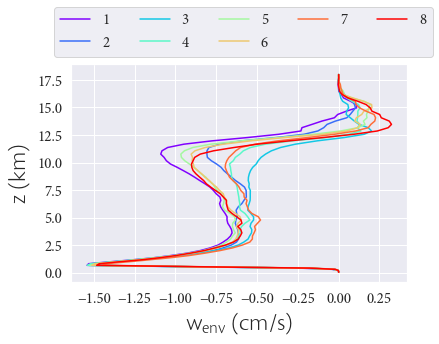

In [6]:
for i in np.arange(len(mwenvlist)):
    plt.plot(mwenvlist[i][0:72]*100, z[0:72]/1000, color=colorlist[i], label=labelslist[i])
plt.xlabel(r'$\mathdefault{w_{env}}$ (cm/s)', fontproperties=Cslabelprop)
plt.ylabel(r'$\mathdefault{z}$ (km)', fontproperties= Cslabelprop)
plt.xticks(font = Mplabelprop)
plt.yticks(font = Mplabelprop)
plt.legend(bbox_to_anchor=(1.1, 1.3), ncol=5, prop=Mplabelprop)
plt.savefig('Figs-Cyclone/wenvz.png',bbox_inches='tight', format='PNG', dpi=600)
plt.show()

As stated previously the total velocity of a parcel moving in the environment is not $\bar{w}_{env}$ for every simulations, because half of them have an imposed large scale velocity $w_{LS}$ at every $z$. To accurately compute the velocity of a parcel moving outside convective clouds we need to compute 
$$
\bar{w}_{tot} = \bar{w}_{env} + w_{LS}
$$
where the bars denote an average over the horizontal grid points. Note that $w_{LS}$ is already defined to be horizontally constant.

The calculation of $w_{LS}$ was made using a prewritten .f90 file that was translated by hand to python. A $\texttt{.h}$ file containing useful physical constants has also been translated and is used in the following cell.

In [7]:
# %run const_thermo.py

# SST = 30
# pp = 1000
# pvzero = 100
# H = 10
pmax = 500

Here we pull data from the .netCDF file yet again to get the pressure as a function of altitude $\texttt{p(z)}$. Where easily doable, parameters where defined using loops.

### Translation of fortran function for $w_{ls}$

Below we use the same looping process to generate the 6 $w_{LS}$ from the function.

In [8]:
wLSlist = []
wLS = ads.WLS(nz,p,pmax,omegamax)[0]
wLSlist.append(wLS)
for i in np.arange(2,nsamples+1):
    locals()["wLS"+str(i)] = ads.WLS(nzlist[i-1],plist[i-1],pmax,omegamaxlist[i-1])[0]
    wLSlist.append(locals()["wLS"+str(i)])
wLSlist = np.asarray(wLSlist)

As the imposed large scale vertical updraft was the same for affected simulations, we only plot 2 cases: one with the large scale updraft and one without

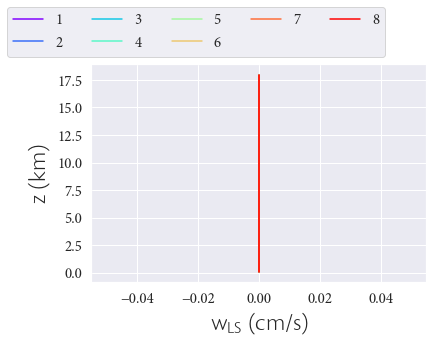

In [9]:
for i in np.arange(len(wLSlist)):
    plt.plot(wLSlist[i]*100, z/1000, color=colorlist[i], label=labelslist[i])
plt.xlabel(r'$\mathdefault{w_{LS}}$ (cm/s)', fontproperties=Cslabelprop)
plt.ylabel(r'$\mathdefault{z}$ (km)', fontproperties=Cslabelprop)
plt.xticks(font = Mplabelprop)
plt.yticks(font = Mplabelprop)
plt.legend(bbox_to_anchor=(0.9, 1.3), ncol=5, prop=Mplabelprop)
plt.savefig('Figs-Cyclone/wLSz.png',bbox_inches='tight', format='PNG', dpi=600)
plt.show()

$\bar{w}_{tot}$ can now be computed for every simulation. Note that $\bar{w}_{tot} = \bar{w}_{env}$ for simulations without large scale updraft.

In [10]:
wtot = ads.WTOT(mwenv, wLS)
wtot2 = ads.WTOT(mwenv2, wLS2)
wtot3 = ads.WTOT(mwenv3, wLS3)
wtot4 = ads.WTOT(mwenv4, wLS4)
wtot5 = ads.WTOT(mwenv5, wLS5)
wtot6 = ads.WTOT(mwenv6, wLS6)
wtot7 = ads.WTOT(mwenv7, wLS7)
wtot8 = ads.WTOT(mwenv8, wLS8)
#wtot9 = ads.WTOT(mwenv9, wLS9)
#wtot10 = ads.WTOT(mwenv10, wLS10)

wtotlist = [wtot, wtot2, wtot3, wtot4, wtot5, wtot6, wtot7, wtot8]#, wtot9]#, wtot10]

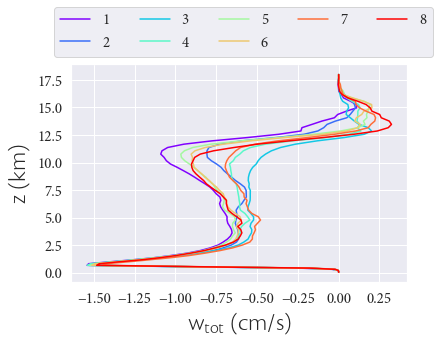

In [11]:
for i in np.arange(len(wtotlist)):
    plt.plot(wtotlist[i]*100, z/1000, color=colorlist[i], label=labelslist[i])
plt.xlabel(r'$\mathdefault{w_{tot}}$ (cm/s)', fontproperties=Cslabelprop)
plt.ylabel(r'$\mathdefault{z}$ (km)', fontproperties=Cslabelprop)
plt.xticks(font = Mplabelprop)
plt.yticks(font = Mplabelprop)
plt.legend(bbox_to_anchor=(1.1, 1.3), ncol=5, prop=Mplabelprop)
plt.savefig('Figs-Cyclone/wtotz.png',bbox_inches='tight', format='PNG', dpi=600)
plt.show()

Now that we have obtained the velocities as a function of $z$ for each day simulated, we need to build the algorithm to take into account the finite vertical speed of the parcel.

Let's assume we can have $z_{clouds}$ for all grid points at every time step (which should be the case). The process could be:  
- At $t_N$ compute max altitude parcel could be coming from $z_{max}(t_N)$
- If $z_{clouds}(t_N) \leq z_{max}(t_N)$:
    - choose this $z_{clouds}$ as altitude of last saturation
- else:
    - compute $z_{max}(t_{N-1})$
    - if $z_{clouds}(t_{N-1}) \leq z_{max}(t_{N-1})$:
        - choose this $z_{clouds}$ as altitude of last saturation

        ...


## Searching for an efficient algorithm

In the introductory paragraph, we oversimplified the problem by considering $w$ constant in $z$, but also by considering that $\Delta t$ was constant between every time step. As we have just shown this is not the case for either. However the introduction was still right about some of the properties of $z_{max}$. It should be highest for low $t_i$ and monotonically decreasing with $t_i$. If there are $N$ time steps, the minimum value should be at $t_N$
$$
\left.z_{max}\right|_{t=t_N} = w_{t_{N-1}}\Delta t_N = w_{t_{N-1}}(t_N - t_{N-1})
$$
as shown in the figure below,

<img src="Figs2/zmax.png" width="400" height="380">

and the maximum value $z_{max}$ can take is at $t_0$. To show this we can use the equation for $\Delta z_i$ shown in the introductory paragraph. At $i = 0$, when $\Delta t$ and $w$ are constant:
$$
z_{max} = \Delta z_{i=0} = (N+1)w\Delta t
$$
However, neither $w(z)$ or $\Delta t(t)$ are constant but $\Delta t(t)$ is nearly constant and could be replaced by a constant. If $\Delta t$ is constant but $w(z)$ is not
$$
z_{max} = \Delta t \left(\sum w_j\right)
$$ 
where the $w_j$ would correspond to the different vertical speeds encountered by the parcel as it moves through the velocity field. $i \neq j$ because the parcel does not necessarily move up by one $z$ increment for one time increment (= its velocity does not change if it moves by less than the interval between two $z$ over a timestep). 




*A look at how time evolves in the simulation*

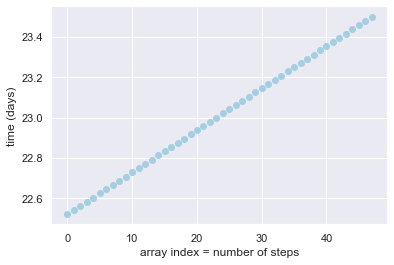

In [12]:
t = data.variables['time'][:]
t += -23
plt.scatter(np.arange(len(t)), t)
plt.xlabel('array index = number of steps')
plt.ylabel('time (days)')
plt.show()

We say $\Delta t$ = 30 min is constant

In [13]:
deltat = 1/48
print('deltat = ', deltat, 'day')
deltat = 30*60
print('       = ', deltat, 's')

deltat =  0.020833333333333332 day
       =  1800 s


Pour chaque n donné, je suis d'accord qu'il faut trouver z_cloud en remontant le temps, de i=n à i=n-njourstraj/deltat, avec njourstraj la durée de la rétro-trajectoire et deltat le pas de temps en jour. ex: pour  njourstraj=8 jours, on va de i=n à n-48*8.
- Prenons n=N. La première chose à faire est de trouver z(i), ce qu'on appelle la rétro-trajectoire de la parcelle.
z(N)=z_parcel  
quelque soit i de N à N-Njourstraj/deltat  
z(i-1)=z(i)-wtot(z(i))*deltat  
Dès que wtot(z(i))>0, tu stoppes la boucle. Ca te donne imin -> tu en déduis le nombre de time steps de ta rétrotrajectoire: ni=N-imin+1  
Cette même rétro-trajectoire pourra être utilisée pour tous les n,x,y.  

- Ensuite, pour chaque n,x,y, tu fais varier i de n à n-ni et tu regardes si tu trouve un nuage entre z(i-1) et z(i), en utilisant les sorties du pas de temps i. Dès que tu trouve un nuage, tu retiens ce z_cloud et tu stoppes la boucle. 

- Enfin, ta pdf de zcloud sera calculée avec tous les zcloud pour chaque n,x,y.


We can merge the time arrays to get a continuous array spanning the 10 days instead of 10 each spanning a day. 

In [14]:
time = np.array([t,t2,t3,t4,t5,t6,t7,t8]).flatten()
(timeshape,) = time.shape
print(timeshape)

384


We can take the mean value of $w_{tot}(z)$ over the 10 days so that $w_{tot}(z,t)$ becomes $w_{tot}(z)$.

In [15]:
wtotlist = np.asarray(wtotlist)
print(wtotlist.shape)
wtotmean = np.mean(wtotlist, axis=0)
print(wtotmean.shape)

(8, 68)
(68,)


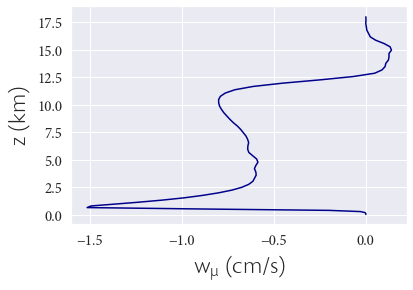

In [16]:
plt.plot(wtotmean*100, z/1000, color='darkblue')
plt.xlabel(r'$\mathdefault{w_{\mu}}$ (cm/s)', fontproperties=Cslabelprop)
plt.ylabel(r'$\mathdefault{z}$ (km)', fontproperties=Cslabelprop)
plt.xticks(font = Mplabelprop)
plt.yticks(font = Mplabelprop)
plt.locator_params(axis="x", nbins=7)
plt.savefig('Figs-Cyclone/wmu.png', bbox_inches='tight', format='PNG', dpi=600)
plt.show()

### Algorithm with $w_{tot}(z,t)$

In [17]:
# ztrajlist=[]
# Ttot = timeshape
# nobs = 10
# for N, wi in zip(np.arange(Ttot-nobs,Ttot,1), np.arange(9,-1,-1)):
#     ztraj = np.zeros(N+1)
#     ztraj[N] = ads.Zparcel(z)[1]
#     maxtraj = np.max(ztraj)
#     i = N-1
#     for j in np.arange( ads.Zparcel(z)[0], np.argmax(z) ):
#         while maxtraj < z[j+1] and i >= 0:
#             ztraj[i] = ztraj[i+1]-wtotlist[wi][j]*deltat
#             maxtraj = np.max(ztraj)
#             i = i-1
#     ztrajlist.append(ztraj)

### Plot of trajectories with $w_{tot}(z,t)$

In [18]:
# labelslist2 = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
# colors = sns.color_palette("Blues", 15)
# for i in np.arange(10):
#     plt.scatter(np.arange(len(ztrajlist[i]))/48, ztrajlist[i]/1000, label=labelslist2[i], s=3, color=colors[i+5])
# plt.xlabel('time (days)', fontproperties=Cslabelprop)
# plt.ylabel(r'$\mathdefault{z}$ (km)', fontproperties=Cslabelprop)
# plt.xticks(font = Mplabelprop)
# plt.yticks(font = Mplabelprop)
# plt.legend(bbox_to_anchor=(1.1,1.3), ncol=5, markerscale=3, prop=Mplabelprop)
# plt.savefig("Figs-Cyclone/ztrajt.png", bbox_inches='tight', format="PNG", dpi=600)
# plt.show()

### Algorithm with $w_{tot}(z)$

In [19]:
ztrajlist=[]
Ttot = timeshape
nobs = 10
for N in np.arange(Ttot-nobs,Ttot,1):
    ztraj = np.zeros(N+1)
    ztraj[N] = ads.Zparcel(z)[1]
    maxtraj = np.max(ztraj)
    i = N-1
    for j in np.arange( ads.Zparcel(z)[0], np.argmax(z) ):
        while maxtraj < z[j+1] and i >= 0:
            ztraj[i] = ztraj[i+1]-wtotmean[j]*deltat
            maxtraj = np.max(ztraj)
            i = i-1
    ztrajlist.append(ztraj)

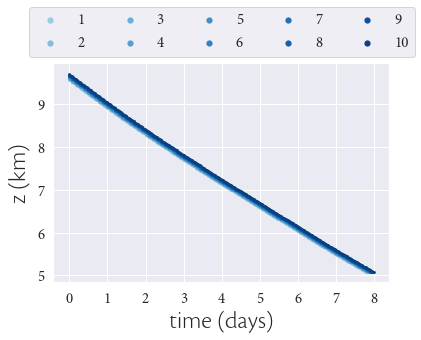

In [20]:
labelslist2 = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
colors = sns.color_palette("Blues", 15)
for i in np.arange(10):
    plt.scatter(np.arange(len(ztrajlist[i]))/48, ztrajlist[i]/1000, label=labelslist2[i], s=3, color=colors[i+5])
plt.xlabel('time (days)', fontproperties=Cslabelprop)
plt.ylabel(r'$\mathdefault{z}$ (km)', fontproperties=Cslabelprop)
plt.xticks(font = Mplabelprop)
plt.yticks(font = Mplabelprop)
plt.legend(bbox_to_anchor=(1.1,1.3), ncol=5, markerscale=3, prop=Mplabelprop)
plt.savefig("Figs-Cyclone/ztraj.png", bbox_inches='tight', format="PNG", dpi=600)
plt.show()

## Finding clouds on the trajectory  

The simple idea would be to simply re-use the $\texttt{LSA}$ function from before, where we would input $z_{traj}$ as the $\texttt{Z}$ parameter.  
But this is incorrect because the function $\texttt{LSA}$ uses values of $q_c$ and $q_i$ that do not correspond to the actual altitude of the parcel defined by the trajectory $z_{traj}$. It is therefore needed to bin $z_{traj}$ in terms of the $z$ discretisation between 5 and 13 km. Then we'll be able to assigne values of $q_i$ qnd $q_c$ to each value of $z_{traj}$.  
The total number of $z$ values is 68 but it spans from $z =$ 0 to $z$ = 18km which is too wide since our parcel only goes from 5 to 13km. The sub-array of $z$ we are interested in is shown below:

In [21]:
print(z[24:52], len(z[24:52]))

[ 5077.64  5374.85  5672.78  5971.24  6270.09  6569.24  6868.61  7168.14
  7467.8   7767.54  8067.35  8367.21  8667.11  8967.03  9266.97  9566.93
  9866.9  10166.9  10466.9  10766.8  11066.8  11366.8  11666.8  11966.8
 12266.8  12566.8  12866.8  13166.8 ] 28


The next step is to put the $z_{traj}$ values into their corresponding bins as defined above. Below is printed the number of $z_{traj}$ values in each corresponding $z$ bin:

In [22]:
ztrajbin = np.zeros(len(ztraj))
ztrajhist = np.histogram(ztraj,bins=z[24:52])
print(ztrajhist)

(array([28, 27, 26, 26, 26, 26, 26, 26, 25, 24, 24, 23, 23, 22, 22, 10,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), array([ 5077.64,  5374.85,  5672.78,  5971.24,  6270.09,  6569.24,
        6868.61,  7168.14,  7467.8 ,  7767.54,  8067.35,  8367.21,
        8667.11,  8967.03,  9266.97,  9566.93,  9866.9 , 10166.9 ,
       10466.9 , 10766.8 , 11066.8 , 11366.8 , 11666.8 , 11966.8 ,
       12266.8 , 12566.8 , 12866.8 , 13166.8 ], dtype=float32))


We now reconstruct the array of 480 values using the binning defined above. 

In [23]:
a=0
b=0
for i in np.arange(len(ztrajhist[0])):
    b+=ztrajhist[0][i]
    ztrajbin[a:b] = ztrajhist[1][i]
    a=b
ztrajbin = np.flip(ztrajbin)

The discretised trajectory can then be plotted.

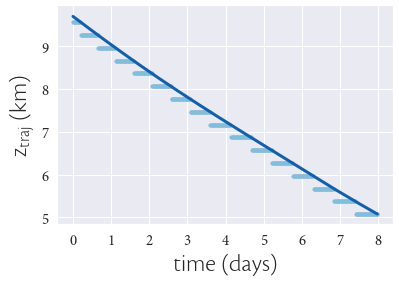

In [24]:
plt.plot(np.arange(len(ztraj))/48, ztraj/1000, color=colors[12], linewidth=3)
plt.scatter(np.arange(len(ztrajbin))/48, ztrajbin/1000, s=10, color=colors[6])
plt.xlabel('time (days)', fontproperties=Cslabelprop)
plt.ylabel(r'$\mathdefault{z_{traj}}$ (km)', fontproperties = Cslabelprop)
plt.xticks(font = Mplabelprop)
plt.yticks(font = Mplabelprop)
plt.savefig("Figs-Cyclone/Discrete_traj.png", bbox_inches='tight',format="PNG", dpi=600)
plt.show()

This process systematically underestimates $z_{traj}$  

#### Generalising to all trajectories

In [25]:
ztrajbinlist = np.zeros(len(ztrajlist), dtype=np.ndarray )
ztrajhistlist = np.zeros(len(ztrajlist), dtype=np.ndarray )
for i in np.arange(len(ztrajbinlist)):
    ztrajbinlist[i] = np.zeros(len(ztrajlist[i]))
    ztrajhistlist[i] = np.histogram(ztrajlist[i],bins=z[24:52])
    a=0
    b=0
    for j in np.arange(len(ztrajhistlist[i][0])):
        b+=ztrajhistlist[i][0][j]
        ztrajbinlist[i][a:b] = ztrajhistlist[i][1][j]
        a=b
    ztrajbinlist[i] = np.flip(ztrajbinlist[i])

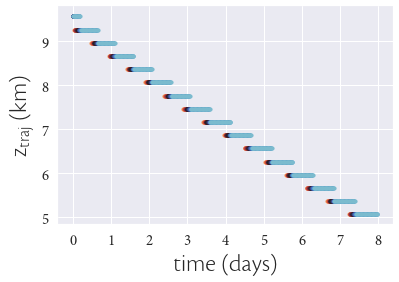

In [26]:
colors_if = sns.color_palette("icefire_r", 10)
for i in np.arange(len(ztrajbinlist)):
    #plt.plot(np.arange(len(ztrajlist[i]))/48, ztrajlist[i]/1000, color=colors[i], linewidth=2)
    plt.scatter(np.arange(len(ztrajbinlist[i]))/48, ztrajbinlist[i]/1000, s=10, color=colors_if[i])
plt.xlabel('time (days)', fontproperties=Cslabelprop)
plt.ylabel(r'$\mathdefault{z_{traj}}$ (km)', fontproperties = Cslabelprop)
plt.xticks(font = Mplabelprop)
plt.yticks(font = Mplabelprop)
plt.savefig("Figs-Cyclone/All_Traj.png", bbox_inches='tight', format="PNG", dpi=600)
plt.show()

Every 48 value in the $z_{trajbin}$ array, time advances by a day. A solution could be to switch array from $q_c$ to $q_{c}2$ etc everytime we advance to a new day, but we can obtain $q_{c,i}$ with the same time dimension as $z_{trajbin}$ by merging all the $q_{c/i}i$ together in one array spanning the 10 days.

In [27]:
qcc = np.array([qc, qc2, qc3, qc4, qc5, qc6, qc7, qc8])#, qc9])#, qc10])
qic = np.array([qi, qi2, qi3, qi4, qi5, qi6, qi7, qi8])#, qi9])#, qi10])

In [28]:
qcc = qcc.reshape(-1, *qcc.shape[-3:])
qic = qic.reshape(-1, *qcc.shape[-3:])

In [29]:
print(qcc.shape,qic.shape)

(384, 68, 128, 128) (384, 68, 128, 128)


In [30]:
zi = []
zlocs = []
for alt in z[24:51]:
    (a,b) = ads.Zloc(np.flip(ztrajbin), alt)
    zi.append(a)
    zlocs.append(b)

From $t$ = 0 to 24, values assigned are $q_{c/i}(t,24,y,x)$. Then from 24 to 46, $q_{c/i}(t,25,y,x)$ and so on..  

In [31]:
ztrajhist

(array([28, 27, 26, 26, 26, 26, 26, 26, 25, 24, 24, 23, 23, 22, 22, 10,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([ 5077.64,  5374.85,  5672.78,  5971.24,  6270.09,  6569.24,
         6868.61,  7168.14,  7467.8 ,  7767.54,  8067.35,  8367.21,
         8667.11,  8967.03,  9266.97,  9566.93,  9866.9 , 10166.9 ,
        10466.9 , 10766.8 , 11066.8 , 11366.8 , 11666.8 , 11966.8 ,
        12266.8 , 12566.8 , 12866.8 , 13166.8 ], dtype=float32))

In [32]:
maxtrajloc = ads.Zloc(z, np.max(ztrajbin))[0]
zparceltraj = ads.Zparcel(z)[0]
zclouds = np.zeros((len(x),len(y)))
izclouds = np.zeros((len(x),len(y)))
thresh = 1e-6
step = 1 # in half hours
for i in tqdmn(np.arange(len(x))):
    for j in tqdmn(np.arange(len(y)), leave=False):
        a=0
        b=0
        cond = np.zeros(len(ztraj))    
        for k,iz in zip(np.arange(len(ztrajhist[0])), np.arange(zparceltraj,maxtrajloc+1)):
            # print('k:', k)
            # print('iz:', iz)
            b+=ztrajhist[0][k]
            for ttime in np.arange(a,b,step):
                # print('ttime:', ttime)
                cond[ttime] = qcc[ttime,iz,j,i] + qic[ttime,iz,j,i]
                a=b
            (matrix,) = np.where(cond>thresh)
            if matrix.shape == (0,):
                zclouds[i,j] = np.max(ztrajbin)   
                izclouds[i,j] = np.argmax(ztrajbin)  
            else: 
                zclouds[i,j] = ztrajbin[-np.min(matrix)]
                izclouds[i,j] = -np.min(matrix)
print(zclouds.shape) 


(128, 128)


In [33]:
np.min(np.where(cond>thresh))
ztrajbin[-60]

5672.77978515625

In [34]:
np.where(np.logical_and(zclouds>=6000, zclouds<=10000))

(array([  0,   0,   0, ..., 127, 127, 127]),
 array([  0,   1,   2, ..., 120, 121, 127]))

<ipython-input-35-1cdbcdb870b7>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  Cloudmap = plt.pcolormesh(x/1000, y/1000, zclouds/1000, cmap="Blues")


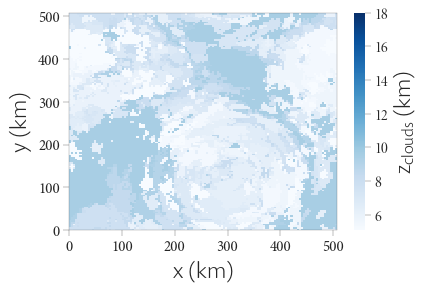

In [35]:
with sns.axes_style("ticks"):
    Cloudmap = plt.pcolormesh(x/1000, y/1000, zclouds/1000, cmap="Blues")
    plt.xlabel(r'$\mathdefault{x}$ (km)', font= Cslabelprop)
    plt.ylabel(r'$\mathdefault{y}$ (km)', font= Cslabelprop)
    cb = plt.colorbar(Cloudmap)
    cb.set_label(r'$\mathdefault{z_{clouds}}$ (km)', font=Cslabelprop)
    cb.outline.set_visible(False)
    plt.clim(vmax=18)
    for l in cb.ax.yaxis.get_ticklabels():
        l.set_family("Minion Pro")
        l.set_size(15)
    plt.xticks(font = Mplabelprop)
    plt.yticks(font = Mplabelprop)
    plt.savefig('Figs-Cyclone/zclouds_traj.png', bbox_inches='tight', format='PNG', dpi=600)
    plt.show()

## Other trajectories  

We can build a function to compute $z_{clouds}$ for other trajectories. We want to be able to change the time step between 2 tests, i.e. test the cloudiness in the parcel every 30min, then every 1h, 2h, etc...

In [36]:
@njit
def LSADYN(Ztrajbin, Ztrajhist, Step):
    maxtrajloc = ads.Zloc(z, np.max(Ztrajbin))[0]
    zparceltraj = ads.Zparcel(z)[0]
    zclouds = np.zeros((len(x),len(y)))
    izclouds = np.zeros((len(x),len(y)))
    thresh = 1e-6
    for i in np.arange(len(x)):
        for j in np.arange(len(y)):
            a=0
            b=0
            cond = np.zeros(len(Ztrajbin))    
            for k,iz in zip(np.arange(len(Ztrajhist[0])), np.arange(zparceltraj,maxtrajloc+1)):
                b+=Ztrajhist[0][k]
                for ttime in np.arange(a,b,Step):
                    cond[ttime] = qcc[ttime,iz,j,i] + qic[ttime,iz,j,i]
                    a=b
            (matrix,) = np.where(cond>thresh)
            if matrix.shape == (0,):
                zclouds[i,j] = np.max(ztrajbin)   
                izclouds[i,j] = np.argmax(ztrajbin)  
            else: 
                zclouds[i,j] = ztrajbin[-np.min(matrix)]
                izclouds[i,j] = -np.min(matrix)
    return izclouds, zclouds

In [37]:
type(qcc)

numpy.ndarray

# Computing the relative humidity

Now we need to calculate the last saturation altitude at every grid point and the predicted humidity $RH = \frac{q_{sat}(z_{cloud})}{q_{sat}(z_{parcel})}$. We need to convert the $z_{traj}$ indices (0-480) to $z$ indices (0-68) using $z_{trajbin}$. 

In [38]:
steplist = [1,2,4,8,16,32,48]
for step in tqdmn(steplist):
    locals()['zcloudslist'+str(step)] = np.zeros((10,128*128), dtype=np.ndarray)
    locals()['zcloudslist'+str(step)][0] = LSADYN(ztrajbinlist[0], ztrajhistlist[0], step)[1].flatten()
    locals()['izclouds'+str(step)] = LSADYN(ztrajbinlist[0], ztrajhistlist[0], step)[0].astype(int)
    locals()['izzclouds'+str(step)] = np.zeros(locals()['izclouds'+str(step)].shape)
    for i in tqdmn(np.arange(len(x)), leave=False):
        for j in np.arange(len(y)):
            (index,) = np.where(ztrajbin[locals()['izclouds'+str(step)][i,j]]==z)
            locals()['izzclouds'+str(step)][i,j] = index
    locals()['izzclouds'+str(step)] = locals()['izzclouds'+str(step)].astype(int)
    for j in tqdmn(np.arange(2,nsamples+1), leave = False):
        locals()['zcloudslist'+str(step)][j-1] = LSADYN(ztrajbinlist[j-1], ztrajhistlist[j-1], step)[1].flatten()
        locals()['izclouds'+str(step)+'_'+str(j)] = LSADYN(ztrajbinlist[j-1], ztrajhistlist[j-1], step)[0].astype(int)
        locals()['izzclouds'+str(step)+'_'+str(j)] = np.zeros(locals()['izclouds'+str(step)+'_'+str(j)].shape)
        for k in np.arange(len(x)):
            for l in np.arange(len(y)):
                (index,) = np.where(ztrajbinlist[j-1][locals()['izclouds'+str(step)+'_'+str(j)][k,l]]==z)
                locals()['izzclouds'+str(step)+'_'+str(j)][k,l] = index
        locals()['izzclouds'+str(step)+'_'+str(j)] = locals()['izzclouds'+str(step)+'_'+str(j)].astype(int)
    locals()['zcloudslist'+str(step)] = locals()['zcloudslist'+str(step)].flatten()

We use the $\texttt{RELHUMP}$ function from $\texttt{altitude_derniere_sat.ipynb}$ to compute $RH$ using $q_{sat}(z_{clouds})$ and $q_{sat}(z_{parcel})$ as explained in the aforementioned notebook.

In [39]:
qssat = np.array([qsat, qsat2, qsat3, qsat4, qsat5, qsat6, qsat7, qsat8])#, qsat9])#, qsat10])
qssat = qssat.reshape(-1, *qssat.shape[-3:])
qssat.shape

(384, 68, 128, 128)

In [40]:
@njit
def RELHUMP(Z,iZclouds):
    RHP = np.empty( (len(x),len(y)) )
    RHP[:,:] = np.nan
    for timez in np.arange(len(time)):
        for i in np.arange(len(x)):
            for j in np.arange(len(y)):
                RHP[i,j] = qssat[timez,iZclouds[i,j],j,i]/qssat[timez,ads.Zparcel(Z)[0],j,i]
    return RHP

# Uncomment following cell to perform $RH$ calculations  

This step takes a long time so the results are run and stored as .txt arrays in the following cell  

#########################################################################################################

In [41]:
for step in tqdmn(steplist):
    izzstep = locals()['izzclouds'+str(step)]
    locals()['RHp'+str(step)] = RELHUMP(z,izzstep)
    np.savetxt('RHarrays/RHp_cyc_NoU'+str(step)+'.txt', locals()['RHp'+str(step)])
    for i in tqdmn(np.arange(2,nsamples+1), leave=False):
        izzstepi = locals()['izzclouds'+str(step)+'_'+str(i)]
        locals()['RHp'+str(step)+'_'+str(i)] = RELHUMP(z,izzstepi)
        np.savetxt('RHarrays/RHp_cyc_NoU'+str(step)+'_'+str(i)+'.txt', locals()['RHp'+str(step)+'_'+str(i)])

#########################################################################################################  

The stored results are extracted in the following cell. We also build the array $\texttt{RHplist}$ which contains all the predicted $RH$ values.

In [42]:
steplist = [1,2,4,8,16,32,48]
print(nsamples)

8


In [43]:
for step in steplist:
    locals()['RHp'+str(step)] = np.loadtxt('RHarrays/RHp_cyc_NoU'+str(step)+'.txt')
    locals()['RHplist'+str(step)] = np.zeros((nsamples, 128*128))
    locals()['RHplist'+str(step)][0] = locals()['RHp'+str(step)].flatten()
    for i in np.arange(2,nsamples+1):
        locals()['RHp'+str(step)+'_'+str(i)] = np.loadtxt('RHarrays/RHp_cyc_NoU'+str(step)+'_'+str(i)+'.txt')
        locals()['RHplist'+str(step)][i-1] = locals()['RHp'+str(step)+'_'+str(i)].flatten()
    locals()['RHplist'+str(step)] = locals()['RHplist'+str(step)].flatten()

In [44]:
RHplist1.shape

(131072,)

In [45]:
nbins = 10
for step in steplist:
    locals()['RHpvszcloudslist'+str(step)] = np.array([locals()['zcloudslist'+str(step)]/1000, locals()['RHplist'+str(step)]])
limits = np.array([[np.min(zclouds)/1000-0.3,np.max(zclouds)/1000],[-0.001, 1.1]])
vslabelslist = np.array(['$\mathdefault{z_{clouds} ~(km)}$', '$\mathdefault{RH_{predicted}}$'], dtype=object)
ncolors = 15
colors = sns.color_palette("Blues", ncolors)

<ipython-input-45-35aa6664dd57>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  locals()['RHpvszcloudslist'+str(step)] = np.array([locals()['zcloudslist'+str(step)]/1000, locals()['RHplist'+str(step)]])


We can now compare the $z_{clouds}$ distribution to the $RH$ predicted from it. Since we use $w_{tot}(z)$ in those calculations, $z_{traj}(t)$ are very similar, so $z_{clouds}$ and $RH$ are also very similar between timesteps.

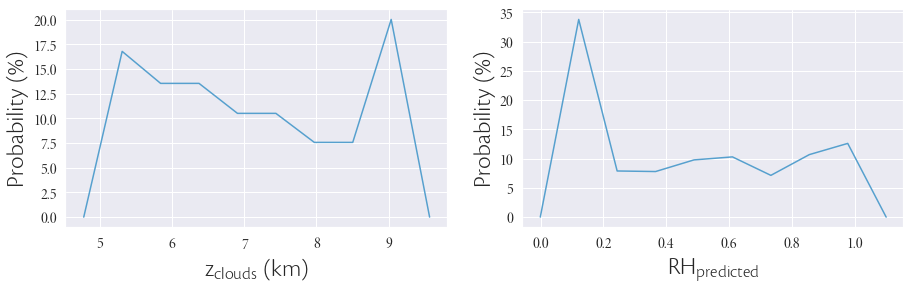

In [46]:
fig, ax = plt.subplots(1,2, figsize = (15,4))
for i in np.arange(len(RHpvszcloudslist1)):
    hist = np.asarray(np.histogram(RHpvszcloudslist1[i], density=True, bins=nbins), dtype=object)
    distrib = sp.rv_histogram(hist)
    xaxis = np.linspace(limits[i][0],limits[i][1],nbins)
    ax[i].plot(xaxis, distrib.pdf(xaxis)/np.sum(distrib.pdf(xaxis))*100, color=colors[8])
    for tick in ax[i].get_xticklabels():
        tick.set_fontname("Minion Pro")
        tick.set_fontsize(15)
    for tick in ax[i].get_yticklabels():
        tick.set_fontname("Minion Pro")
        tick.set_fontsize(15)
    ax[i].set_xlabel(vslabelslist[i], fontproperties=Cslabelprop)
    ax[i].set_ylabel('Probability (%)', fontproperties=Cslabelprop)
plt.savefig('Figs-Cyclone/zcloudsvsRHp.png', bbox_inches='tight', format='PNG', dpi=600)
plt.show()

In [49]:
len(zcloudslist1)

163840

In fact the distributions perfectly superimpose, as seen above.  
We would like to compare this result to the previous ones (shown in $\texttt{altitude_derniere_sat.ipynb}$). For this we import $z_{cloudso}$ and $RH_{po}$ using the $\texttt{%store}$ magic. These values are calculated using the static method (altitude of clouds above 5km at $t$ = last saturation altitude of tropospheric parcel at $t$).

In [50]:
%store -r zcloudso_cyc_NoU
%store -r RHpo_cyc_NoU

In [51]:
nbins = 10
limits = np.array([[np.min(zcloudso_cyc_NoU)/1000-0.3,np.max(zcloudso_cyc_NoU)/1000],[0, 1.1]])
colors = sns.color_palette("Blues", 4)
labelslist = ['Static', 'Dynamic', 'Actual']
zcovsn = np.array([zcloudso_cyc_NoU, zclouds], dtype=object)
RHpovsn = np.array([RHpo_cyc_NoU, RHplist1], dtype=object)
Newvs = np.asarray([zcovsn/1000, RHpovsn], dtype=object)

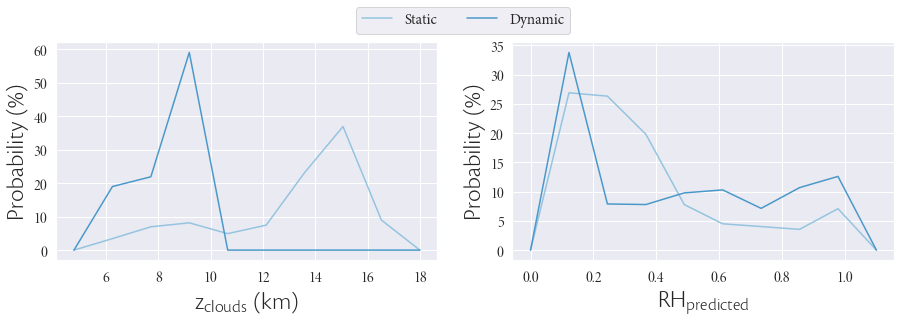

In [52]:
fig, ax = plt.subplots(1,2, figsize = (15,4))
for i in np.arange(len(Newvs)):
    for j in np.arange(len(zcovsn)):
        hist = np.asarray(np.histogram(Newvs[i,j], density=True, bins=nbins), dtype=object)
        distrib = sp.rv_histogram(hist)
        xaxis = np.linspace(limits[i][0],limits[i][1],nbins)
        ax[i].plot(xaxis, distrib.pdf(xaxis)/np.sum(distrib.pdf(xaxis))*100, color=colors[j+1], label=labelslist[j])
    for tick in ax[i].get_xticklabels():
        tick.set_fontname("Minion Pro")
        tick.set_fontsize(15)
    for tick in ax[i].get_yticklabels():
        tick.set_fontname("Minion Pro")
        tick.set_fontsize(15)
    ax[i].set_xlabel(vslabelslist[i], fontproperties=Cslabelprop)
    ax[i].set_ylabel('Probability (%)', fontproperties=Cslabelprop)
plt.legend(bbox_to_anchor=(0.17, 1.2), ncol=5, prop=Mplabelprop)
plt.savefig('Figs-Cyclone/zcloudsvsRHpStatDyn.png', bbox_inches='tight', format='PNG', dpi=600)
plt.show()

We can now compare the dynamic result to the actual $RH$ calculated using $\frac{q_v(z_{parcel})}{q_{sat}(z_{parcel})}$. To do so we import $Rh$ from $\texttt{altitude_derniere_sat.ipynb}$ using the same method as before.

In [53]:
%store -r Rh3
RHcomplist = np.array([RHpo_cyc_NoU, RHplist1, Rh3], dtype=object)

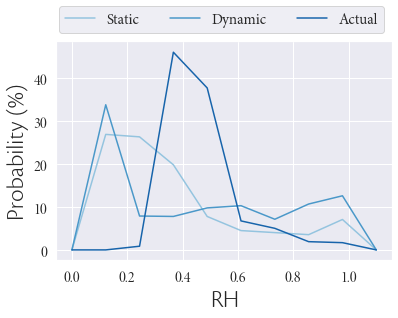

In [54]:
fig, ax = plt.subplots()
for j in np.arange(len(RHcomplist)):
    hist = np.asarray(np.histogram(RHcomplist[j], density=True, bins=nbins), dtype=object)
    distrib = sp.rv_histogram(hist)
    xaxis = np.linspace(limits[1][0],limits[1][1],nbins)
    ax.plot(xaxis, distrib.pdf(xaxis)/np.sum(distrib.pdf(xaxis))*100, color=colors[j+1], label=labelslist[j])
for tick in ax.get_xticklabels():
    tick.set_fontname("Minion Pro")
    tick.set_fontsize(15)
for tick in ax.get_yticklabels():
    tick.set_fontname("Minion Pro")
    tick.set_fontsize(15)
ax.set_xlabel('$\mathdefault{RH}$', fontproperties=Cslabelprop)
ax.set_ylabel('Probability (%)', fontproperties=Cslabelprop)
plt.legend(bbox_to_anchor=(1, 1.2), ncol=5, prop=Mplabelprop)
plt.savefig('Figs-Cyclone/RhvsRHovsRHp.png', bbox_inches='tight', format='PNG', dpi=600)
plt.show()

In [55]:
RHpcomplist = np.array([RHplist1, RHplist2, RHplist4, RHplist8, RHplist16, RHplist32, RHplist48], dtype=object)
steplabels = ['30min', '1h', '2h', '4h', '8h', '16h', '24h' ]
colors = sns.color_palette("Blues", 15)

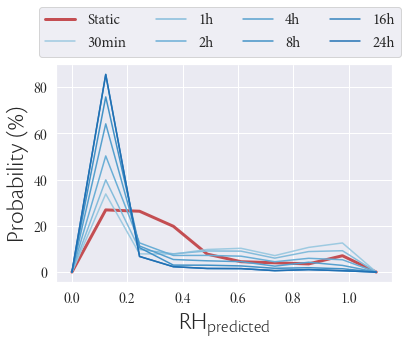

In [56]:
fig, ax = plt.subplots()
hist = np.asarray(np.histogram(RHpo_cyc_NoU, density=True, bins=nbins), dtype=object)
distrib = sp.rv_histogram(hist)
xaxis = np.linspace(limits[1][0],limits[1][1],nbins)
plt.plot(xaxis, distrib.pdf(xaxis)/np.sum(distrib.pdf(xaxis))*100, color='r', label='Static', linewidth=3)
for j in np.arange(len(RHpcomplist)):
    hist = np.asarray(np.histogram(RHpcomplist[j], density=True, bins=nbins), dtype=object)
    distrib = sp.rv_histogram(hist)
    xaxis = np.linspace(limits[1][0],limits[1][1],nbins)
    ax.plot(xaxis, distrib.pdf(xaxis)/np.sum(distrib.pdf(xaxis))*100, color=colors[j+5], label=steplabels[j])
for tick in ax.get_xticklabels():
    tick.set_fontname("Minion Pro")
    tick.set_fontsize(15)
for tick in ax.get_yticklabels():
    tick.set_fontname("Minion Pro")
    tick.set_fontsize(15)
ax.set_xlabel('$\mathdefault{RH_{predicted}}$', fontproperties=Cslabelprop)
ax.set_ylabel('Probability (%)', fontproperties=Cslabelprop)
plt.legend(bbox_to_anchor=(1.05, 1.3), ncol=4, prop=Mplabelprop)
plt.savefig('Figs-Cyclone/RHps.png', bbox_inches='tight', format='PNG', dpi=600)
plt.show()

In [57]:
meanRHplist = np.zeros(len(RHpcomplist))
for step, i in zip(steplist, np.arange(len(steplist))):
    locals()['meanRHp'+str(step)] = np.mean(locals()['RHplist'+str(step)])
    meanRHplist[i] = locals()['meanRHp'+str(step)]

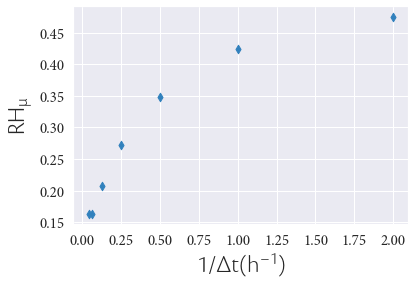

In [58]:
# ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')¶
plt.scatter(1/(np.asarray(steplist)*0.5), meanRHplist, color=colors[10], marker='d')
plt.xlabel('$\mathdefault{1/\Delta t (h^{-1})}$', fontproperties=Cslabelprop)
plt.ylabel(r'$\mathdefault{RH_{\mu}}$', fontproperties=Cslabelprop)
#plt.xlim(25,0)
plt.xticks(font = Mplabelprop)
plt.yticks(font = Mplabelprop)
plt.savefig('Figs-Cyclone/meanRHvsDt.png', bbox_inches='tight', format='PNG', dpi=600)
plt.show()

In [59]:
meanRHplist_cyc_NoU = meanRHplist
%store meanRHplist_cyc_NoU

Stored 'meanRHplist_cyc_NoU' (ndarray)


In [77]:
print(data.variables)

{'QC': <class 'netCDF4._netCDF4.Variable'>
float32 QC(time, z, y, x)
    long_name: CLOUD WATER MASS MIXING RATIO                                                   
    units: g/kg      
unlimited dimensions: time
current shape = (48, 68, 128, 128)
filling on, default _FillValue of 9.969209968386869e+36 used, 'QI': <class 'netCDF4._netCDF4.Variable'>
float32 QI(time, z, y, x)
    long_name: CLOUD ICE MASS MIXING RATIO                                                     
    units: g/kg      
unlimited dimensions: time
current shape = (48, 68, 128, 128)
filling on, default _FillValue of 9.969209968386869e+36 used, 'QSAT': <class 'netCDF4._netCDF4.Variable'>
float32 QSAT(time, z, y, x)
    long_name: Saturation specific humidity                                                    
    units: g/kg      
unlimited dimensions: time
current shape = (48, 68, 128, 128)
filling on, default _FillValue of 9.969209968386869e+36 used, 'QV': <class 'netCDF4._netCDF4.Variable'>
float32 QV(time, z, y, 

In [78]:
np.asarray(steplist)*30/60

array([ 0.5,  1. ,  2. ,  4. ,  8. , 16. , 24. ])